# Import data
Import data downloaded from lantmäteriet (https://geotorget.lantmateriet.se/geodataprodukter/markhojdmodell-nedladdning-api)

In [24]:

from storm_water_management import utils

import matplotlib.pyplot as plt
#from utils import get_tif_as_np_array, get_tif_from_np_array, info
from whitebox_workflows import WbEnvironment, show

filename_path = "/home/chris/repos/storm_temp/data/1m"
filename = "63950_3150_25.tif"


Rows: 2500
Columns: 2500
Resolution (x direction): 5.952481842654712e-06
Resolution (y direction): 6.364472054103778e-06
North: 61.73501615516182
South: 61.71911133949862
East: 1.9621015094522267
West: 1.9472262573274326
Min value: inf
Max value: -inf
EPSG code: 4326
Nodata value: -9999.0
Data type: RasterDataType.F32
Photometric interpretation: PhotometricInterpretation.Continuous
****************************************************
* Welcome to fill_depressions_planchon_and_darboux *
* Powered by Whitebox Workflows for Python         *
* www.whiteboxgeo.com                              *
****************************************************
progress (Loop 1): 0%
progress (Loop 1): 1%
progress (Loop 1): 2%
progress (Loop 1): 3%
progress (Loop 1): 4%
progress (Loop 1): 5%
progress (Loop 1): 6%
progress (Loop 1): 7%
progress (Loop 1): 8%
progress (Loop 1): 9%
progress (Loop 1): 10%
progress (Loop 1): 11%
progress (Loop 1): 12%
progress (Loop 1): 13%
progress (Loop 1): 14%
progress (Loop 

/tmp/ipykernel_18984/2765780132.py:37: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


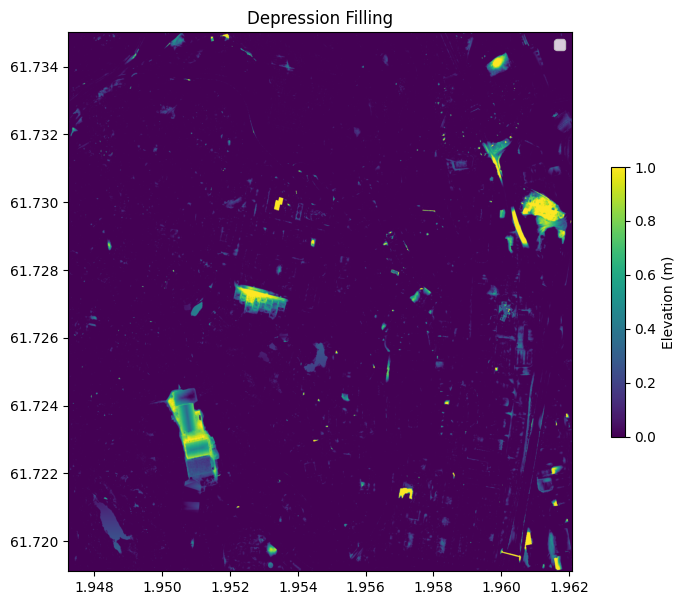

In [25]:
"""Main function."""
wbe = WbEnvironment()
wbe.verbose = True
wbe.working_directory = filename_path
dem = wbe.read_raster(filename)

raster_as_array = utils.get_tif_as_np_array(filename_path, filename)
dem_from_array = utils.get_tif_from_np_array(dem, raster_as_array)
utils.info(dem_from_array)

# Smooth DEM. Parameters need to be set to proper values.
# dem_smoothed = wbe.feature_preserving_smoothing(dem_from_array, filter_size=11, normal_diff_threshold=10.0, iterations=3)
dem_smoothed = dem_from_array
# Fill depressions
dem_no_deps = wbe.fill_depressions_planchon_and_darboux(
    dem_smoothed, flat_increment=0.001
)
# dem_no_deps = wbe.fill_depressions(dem_smoothed, flat_increment=0.001)
# dem_no_deps = wbe.fill_depressions_wang_and_liu(dem_smoothed, flat_increment=0.001)
depression_depth = wbe.raster_calculator(
    "('dem_no_deps'-'dem')", [dem_no_deps, dem_from_array]
)
# wbe.write_raster(depression_depth, filename + 'depression_depth.tif')

# Plot depression filling
fig, ax = plt.subplots()
ax = show(
    depression_depth,
    ax=ax,
    title="Depression Filling",
    figsize=(10, 7),
    colorbar_kwargs={"label": "Elevation (m)", "location": "right", "shrink": 0.5},
    zorder=1,
    vmin=0,
    vmax=1,
)
ax.legend()
plt.show()

    



In [26]:
# Flow accumulation analysis
channel_threshold = 50000.0
flow_accum = wbe.qin_flow_accumulation(dem_no_deps, out_type='cells', convergence_threshold=channel_threshold, log_transform=True)
# wbe.write_raster(flow_accum, filename + 'flow_accum.tif'))


********************************************
* Welcome to qin_flow_accumulation         *
* Powered by Whitebox Workflows for Python *
* www.whiteboxgeo.com                      *
********************************************
Num. inflowing neighbours: 0%
Num. inflowing neighbours: 1%
Num. inflowing neighbours: 2%
Num. inflowing neighbours: 3%
Num. inflowing neighbours: 4%
Num. inflowing neighbours: 5%
Num. inflowing neighbours: 6%
Num. inflowing neighbours: 7%
Num. inflowing neighbours: 8%
Num. inflowing neighbours: 9%
Num. inflowing neighbours: 10%
Num. inflowing neighbours: 11%
Num. inflowing neighbours: 12%
Num. inflowing neighbours: 13%
Num. inflowing neighbours: 14%
Num. inflowing neighbours: 15%
Num. inflowing neighbours: 16%
Num. inflowing neighbours: 17%
Num. inflowing neighbours: 18%
Num. inflowing neighbours: 19%
Num. inflowing neighbours: 20%
Num. inflowing neighbours: 21%
Num. inflowing neighbours: 22%
Num. inflowing neighbours: 23%
Num. inflowing neighbours: 24%
Num. inflo

/tmp/ipykernel_18984/1431786171.py:10: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


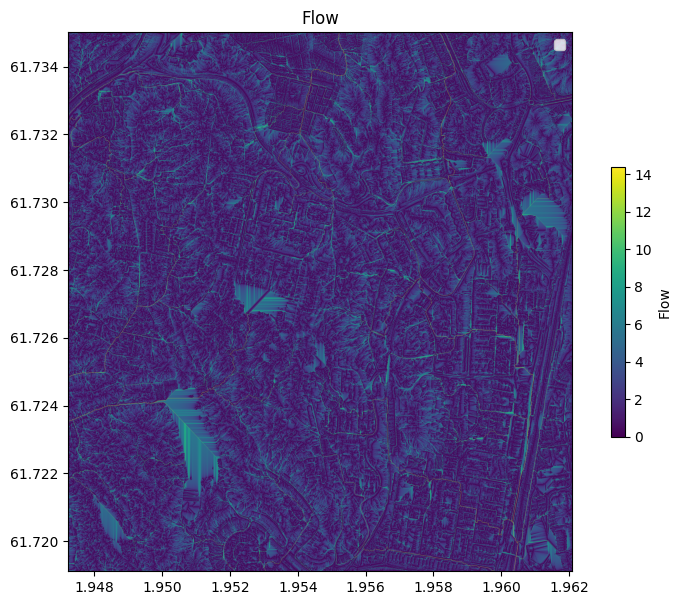

In [27]:
fig, ax = plt.subplots()
ax = show(
    flow_accum,
    ax=ax,
    title="Flow",
    figsize=(10, 7),
    colorbar_kwargs={"label": "Flow", "location": "right", "shrink": 0.5},
    zorder=1,
)
ax.legend()
plt.show()